# Image classification using CNNs in Keras

The goal of the project is to create a classifier capable of determining a plant's
species from a photo.

### Mount Drive

In [137]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import necessary libraries

In [138]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load Data

#### Load Images

In [139]:
images_file_path = '/content/drive/My Drive/Colab Notebooks/images.npy';

images = np.load(images_file_path)
images.shape

(4750, 128, 128, 3)

#### Load Labels

In [140]:
labels_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Labels.csv')
labels_df.head(10)

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill
5,Small-flowered Cranesbill
6,Small-flowered Cranesbill
7,Small-flowered Cranesbill
8,Small-flowered Cranesbill
9,Small-flowered Cranesbill


In [141]:
labels_df.shape

(4750, 1)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


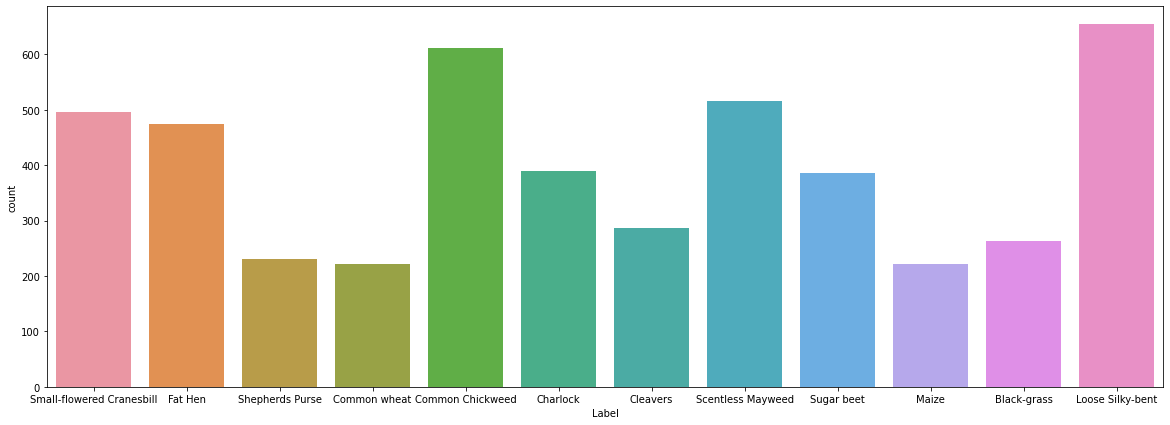

In [142]:
plt.figure(figsize=(20,7))
sns.countplot(labels_df['Label']);

#### Visualize Images

Small-flowered Cranesbill


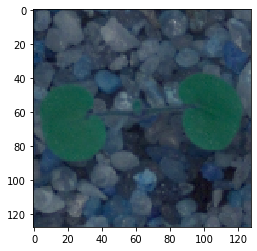

Fat Hen


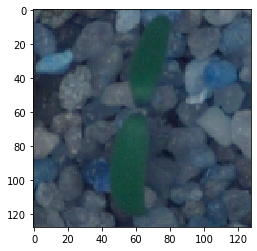

Shepherds Purse


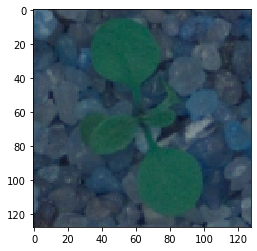

Common wheat


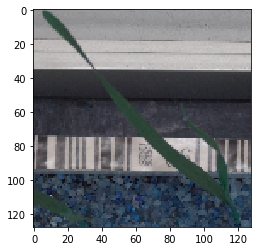

Common Chickweed


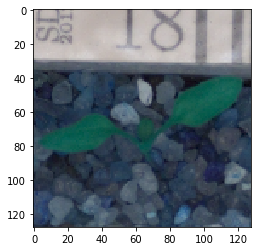

Charlock


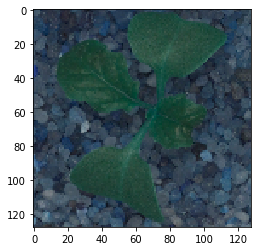

Cleavers


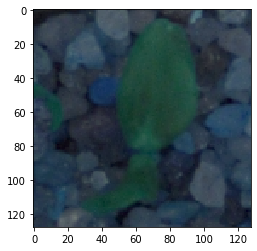

Scentless Mayweed


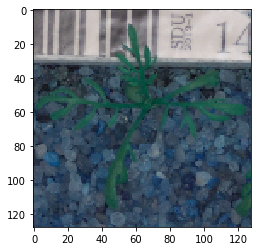

Sugar beet


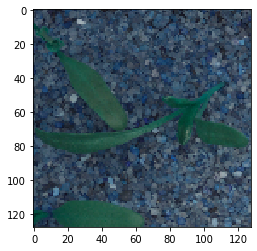

Maize


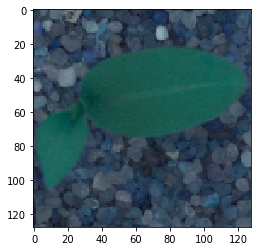

Black-grass


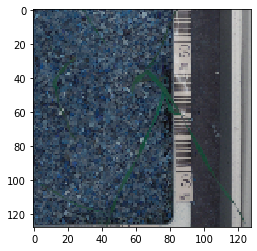

Loose Silky-bent


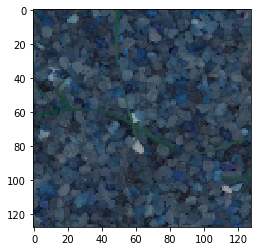

In [143]:
for label in labels_df['Label'].unique():
  row_index = labels_df[labels_df['Label'] == label].index[0]
  print(label)
  plt.imshow(images[row_index], interpolation='nearest')
  plt.show()

### Preprocess Images

#### Normalize Images

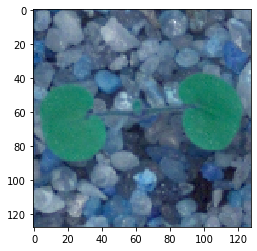

In [144]:
norm_imgs = np.array([cv2.normalize(
    img, 
    None, 
    alpha=0, 
    beta=1, 
    norm_type=cv2.NORM_MINMAX, 
    dtype=cv2.CV_32F) for img in images])

plt.imshow(norm_imgs[0], interpolation='nearest')
plt.show()

### Blurr Images

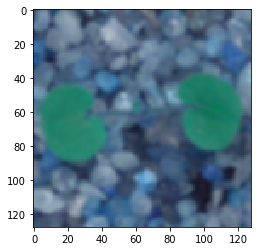

In [145]:
blurred_imgs = []

for img in norm_imgs:
  blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
  blurred_imgs.append(blurred_img)

blurred_imgs = np.array(blurred_imgs)
plt.imshow(blurred_imgs[0], interpolation='nearest', cmap=plt.cm.gray)
plt.show()

### Convert Labels to One Hot Vectors

In [146]:
from keras.utils import to_categorical

y_one_hot_df = pd.get_dummies(labels_df)
y_one_hot_df.head()

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0


In [147]:
y = y_one_hot_df.to_numpy()
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

### Split data into Train, Validation and Test sets

In [148]:
from sklearn.model_selection import train_test_split
x = blurred_imgs

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [149]:
print(f'Train shape {x_train.shape}')
print(f'Val shape {x_val.shape}')
print(f'Test shape {x_test.shape}')

Train shape (3325, 128, 128, 3)
Val shape (713, 128, 128, 3)
Test shape (712, 128, 128, 3)


There's no need to resize the image data because it's already in the needed number of dimensions for building the model.

## Build CNN Model

In [215]:
from tensorflow.keras import models, layers, optimizers

tf.random.set_seed(0)
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=x_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(12, activation="softmax"))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
global_max_pooling2d_15 (Glo (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_27 (Dense)             (None, 12)              

In [216]:
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [217]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [218]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training
checkpoint_file_path = '/content/drive/My Drive/Colab Notebooks/checkpoint'
model_checkpoint =  ModelCheckpoint(filepath=checkpoint_file_path,
                                                           monitor='accuracy',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq=1)

Epoch 1/300

Epoch 00001: accuracy improved from -inf to 0.09800, saving model to /content/drive/My Drive/Colab Notebooks/checkpoint
1/7 [===>..........................] - ETA: 0s - loss: 5.6918 - accuracy: 0.0980
Epoch 00001: accuracy improved from 0.09800 to 0.11900, saving model to /content/drive/My Drive/Colab Notebooks/checkpoint
2/7 [=======>......................] - ETA: 0s - loss: 4.9945 - accuracy: 0.1190WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0835s vs `on_train_batch_end` time: 0.1647s). Check your callbacks.

Epoch 00001: accuracy improved from 0.11900 to 0.12667, saving model to /content/drive/My Drive/Colab Notebooks/checkpoint
3/7 [===========>..................] - ETA: 0s - loss: 4.4845 - accuracy: 0.1267
Epoch 00001: accuracy did not improve from 0.12667
4/7 [================>.............] - ETA: 0s - loss: 4.1592 - accuracy: 0.1250
Epoch 00001: accuracy did not improve from 0.12667
5/7 [===============

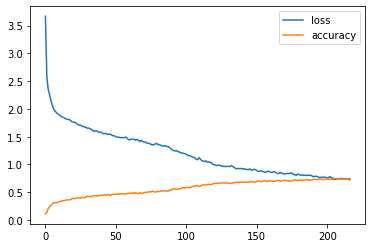

In [219]:
history = model.fit(x_train,
                    y_train,
                    batch_size=500,
                    epochs=300,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

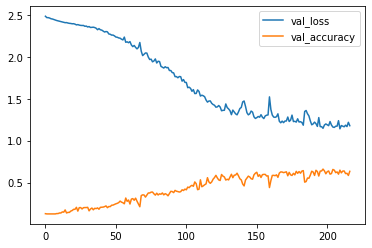

In [220]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [221]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 6ms/step - loss: 1.0993 - accuracy: 0.6573
Test loss: 1.0992579460144043
Test accuracy: 0.6573033928871155


In [222]:
def predict_image_label(model, test_image_index):
  pred = model.predict(np.array([x_test[test_image_index]]))
  pred_label_index = np.argmax(pred[0])
  correct_label_index = np.argmax(y_test[test_image_index])

  print(f'Predicted Label: {y_dummies.columns[pred_label_index][6:]}')
  print(f'Correct Label: {y_dummies.columns[correct_label_index][6:]}')

  plt.imshow(x_test[test_image_index], interpolation='nearest')
  plt.show()


Predicted Label: Maize
Correct Label: Maize


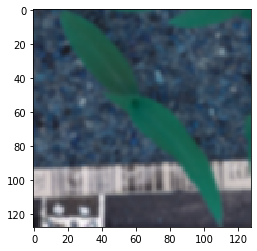

In [223]:
predict_image_label(model, 2);

Predicted Label: Fat Hen
Correct Label: Small-flowered Cranesbill


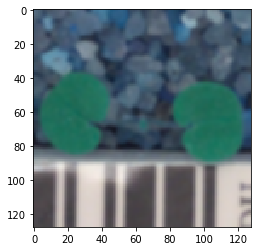

In [224]:
predict_image_label(model, 3);

Predicted Label: Scentless Mayweed
Correct Label: Common Chickweed


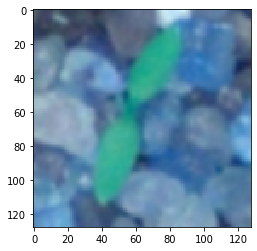

In [225]:
predict_image_label(model, 33);

Predicted Label: Fat Hen
Correct Label: Fat Hen


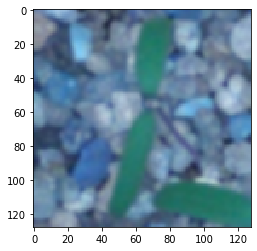

In [226]:
predict_image_label(model, 36);

Predicted Label: Sugar beet
Correct Label: Sugar beet


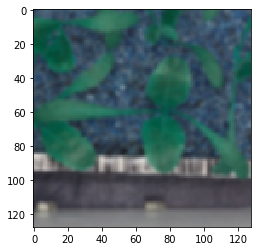

In [227]:
predict_image_label(model, 59);